## MazeChallenge
Fondamentalmente l'algortmo si basa sul muoversi ad ogni turno preferendo le caselle non esplorate.
1. Contollo se nelle caselle vicine è diponibile una nuova casella, in caso positivo mi ci muovo e la memorizzo in caselle_fatte.
2. Nel caso non siano diponibili si muove in quelle già percorse che non siano quella di partenza o appertenti ad una lista (caselle_chiuse) di celle segnalate come parte ad un vicolo cieco.
3. Nel caso anche questo non fosse possibile torna indietro, segnalando il vicolo cieco.

procendo in loop finchè non soddisfo una certa condizione, ad es un certo numero di iterazioni solo con caselle ripetute.(Si poteva anche confrontare la lista di quelle fatte con una contenente tutte le caselle vicine per quelcosa di meno casuale)

Funzioni necessarie per l'esploratore:

In [5]:
import mazeClient
import json
from time import sleep
import matplotlib.pyplot as plt
import random
import pandas as pd
# assegnati due punti (attuale e da raggiugere) da restitusce action opportuna
def Assegnatrice_Comando(x0,y0,x1,y1,command): 
    # print(f'Provo movimento {[x0,y0]} ==> {[x1,y1]}')
    dy = -(x1-x0) # matrice direzionata
    dx = (y1-y0)
    if(abs(dx) == 1 and dy == 0):
        if(dx == 1):
            action = 1 # command.MOVE_LEFT
        else:
            action = 2 #command.MOVE_RIGHT
    elif(abs(dy) == 1 and dx == 0):
        if(dy == 1):
            action = 3 #command.MOVE_DOWN
        else:
            action = 4 #command.MOVE_UP
    else:
        action = False #Non valido
    return action

# Deciso come muoversi esegue il movimento
def movimento(flag: int,command):
    if flag == 1:
        action = command.MOVE_LEFT
        # print('eseguito left')
    elif flag == 2:
        action = command.MOVE_RIGHT
        # print('eseguito right')
    elif flag == 3:
        action = command.MOVE_DOWN
        # print('eseguito down')
    elif flag == 4:
        action = command.MOVE_UP
        # print('eseguito up')
    else:
        print('Errore!!!')
        # print('rifiutato')
    return json.loads(mazeClient.send_command(action))

def esploratore(path,Nlim):
    command = mazeClient.Commands
    caselle_fatte = []
    caselle_chiuse = [] # lista nera delle caselle
    k = 0 # ripetizione caselle fatte
    res = json.loads(mazeClient.send_command(command.MOVE_DOWN)) # inizializzo per avere il primo stato
    # x posizione attuale, x_p posizione precedente, x_s la successiva
    flag = 0
    while(k<Nlim): # a tot caselle ripetute considero il labirinto esplorato
        x = [res['userX'],res['userY']]
        # sleep(0.3)
        # print('-'*24)
        # print(f'** posizione attuale: {x}')
        vicini = []
        for i in res['Neighbors']: # elimino gli spostamenti impossibili ==> lista vicini
            x_s = [i['x'],i['y']]
            action = Assegnatrice_Comando(*x,*x_s,command)
            if(action):
                # print('Ok, possibile')
                vicini.append([*x_s,i['val'],action])
        random.shuffle(vicini) # per evitare loop (es 4 caselle)
        # controllo se ci sono caselle nuove        
        for i in vicini:
            if [i[0],i[1],i[2]] not in caselle_fatte:
                # print('Nuova casella!')
                action = i[3]
                caselle_fatte.append([i[0],i[1],i[2]])
                flag = 1
                k = 0
                break
        # se non ci sono, controllo quindi se posso tornare su una vecchia che non sia nella lista chiusa o quella da dove vengo
        if(flag == 0):
            for i in vicini:
                if x_p != [i[0],i[1]] and [i[0],i[1]] not in caselle_chiuse:
                    action = i[3]  
                    k = k+1
                    flag = 1
                    break
        # se non ci sono, torno quella da dove venivo e inserisco nella lista di caselle chiuse quella attuale
        if(flag == 0):
            # print('Casella cieca')
            x_s = x_p
            caselle_chiuse.append([*x])
            idx = [[row[0],row[1]] for row in vicini].index(x_s)
            action = vicini[idx][3] 
            k = k+1
        # print(f'Movimento {x} ==> {x_s}')
        res = movimento(action,command)
        flag = 0 
        x_p = x
    mazeClient.send_command(command.EXIT)
    # Salvo il file
    with open(path,"w") as file_:
            file_.write(f'x;y;colore\n')
            for i in caselle_fatte:
                file_.write(f'{i[0]};{i[1]};{i[2]}\n')
    return caselle_fatte

# trasformo i dati sulle caselle esplorate e prendo le caratteristiche d'interesse
def analisi(dati):
    maze = pd.DataFrame(dati,columns=['x', 'y', 'colore'])
    maze['colore'].replace({32: 'w',66:'b',71:'g',82:'r'}, inplace=True) # sostituisco i colori con valori adatti al plot
    maze['frequenza'] = 1 - maze['colore'].str.count('w') # distribuzione dei punti cololorati (nelle caselle)
    n = [0]*3 # vettore rgb sul numero assoluto di colori
    n[0] = maze['colore'].str.count('r').sum()
    n[1] = maze['colore'].str.count('g').sum()
    n[2] = maze['colore'].str.count('b').sum()
    fxc = maze.groupby(maze['x'])['frequenza'].sum() # distribuzione sulle x del colore
    fyc = maze.groupby(maze['y'])['frequenza'].sum() # distribuzione sulle y del colore
    return maze,fxc,fyc,n


Programma main principale, richiame le funzioni precenti e fa il plot.

Avviato il programma maze? [invio per continuare] ... 
Caselle esplorate sono 134
Di cui in sono [nR,nG,nB] = [40, 32, 29] 
Mappa del labirinto


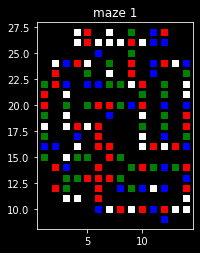

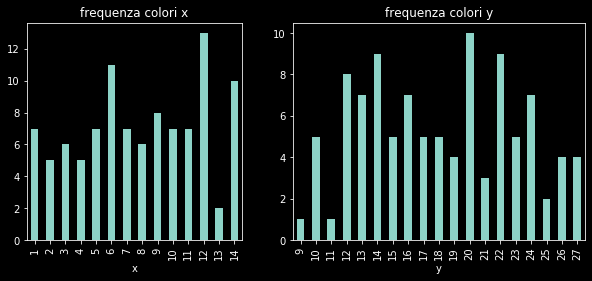

riavviato il programma maze e cambiato seed? [invio per continuare] ... 
Caselle esplorate sono 243
Di cui in sono [nR,nG,nB] = [74, 57, 58] 


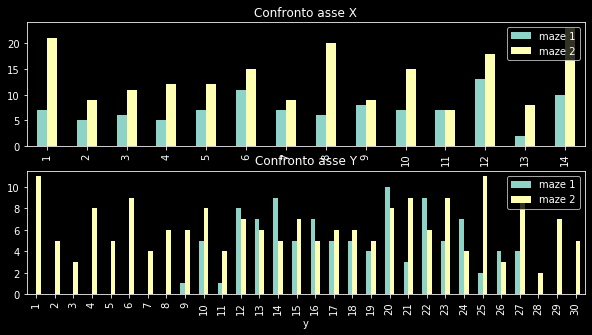

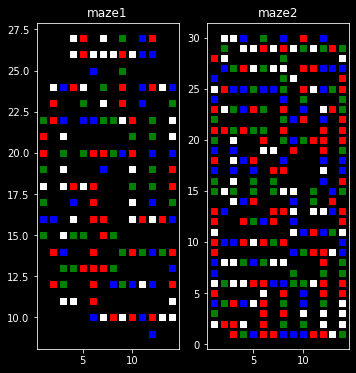

In [9]:
%matplotlib inline


def main():
    N = 500
    input('Avviato il programma maze? [invio per continuare] ... ')
    path = "maze1.txt"
    flag = True
    while(flag):
        try:
            maze = esploratore(path,N)
            maze1,fxc1,fyc1,c = analisi(maze)
            print(f'Caselle esplorate sono {len(maze)}') # totale celle
            print(f'Di cui in sono [nR,nG,nB] = {[c[0],c[1],c[2]]} ') # celle per colore
            # plot 1
            plt.style.use('dark_background')
            # mappa
            print('Mappa del labirinto')
            fig_1,ax = plt.subplots(1,figsize=(0.2*len(fxc1),0.2*len(fyc1))) 
            ax.set(title = 'maze 1')
            ax.scatter(maze1['x'],maze1['y'],c=maze1['colore'],marker='s')
            # frequenza
            fig_2,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4),gridspec_kw={'width_ratios': [len(fxc1)/(len(fxc1)+len(fyc1)), len(fyc1)/(len(fxc1)+len(fyc1))]})
            ax1.set(title = 'frequenza colori x',xlabel='x')
            fxc1.plot.bar(ax = ax1)
            ax2.set(title = 'frequenza colori y',xlabel='x')
            fyc1.plot.bar(ax = ax2)
            flag = False
            plt.show()
        except ConnectionRefusedError:
            print('Programma non avviato')
    # -------------------------------------------------------------------------------
    sleep(5)
    input('riavviato il programma maze e cambiato seed? [invio per continuare] ... ')
    path = "maze2.txt"
    flag = True
    while(flag):
        try:
            maze = esploratore(path,N)
            maze2,fxc2,fyc2,c = analisi(maze)
            print(f'Caselle esplorate sono {len(maze)}') # totale celle
            print(f'Di cui in sono [nR,nG,nB] = {[c[0],c[1],c[2]]} ') # celle per colore
            #
            fxc = pd.concat([fxc1,fxc2],axis=1, sort=False)
            fxc.columns = ['maze 1', 'maze 2']
            fyc = pd.concat([fyc1,fyc2],axis=1, sort=False)
            fyc.columns = ['maze 1', 'maze 2']
            # plot 2 Confornto
            # frequenza
            fig_1,(ax1,ax2) = plt.subplots(2,1,figsize=(10,5))
            ax1.set(title='Confronto asse X')
            fxc.plot.bar(ax=ax1)
            plt.title('maze 2')
            fyc.plot.bar(ax=ax2)
            ax2.set(title='Confronto asse Y')
            # mappa
            lfxc = max([len(fxc1),len(fxc2)])
            lfyc = max([len(fyc1),len(fyc2)])
            fig_1,(ax3,ax4) = plt.subplots(1,2,figsize=(0.4*lfxc,0.2*lfyc))
            ax3.set(title='maze1')
            ax4.set(title ='maze2')
            ax3.scatter(maze1['x'],maze1['y'],c=maze1['colore'],marker='s')
            ax4.scatter(maze2['x'],maze2['y'],c=maze2['colore'],marker='s')
            plt.show()
            flag = False
        except ConnectionRefusedError:
            print('Programma non avviato')
            sleep(5)
            
if __name__ == '__main__':
    main()   